In [1]:
import os
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn.functional as F
import time

In [2]:
def load_example(df_row):
    image = torchvision.io.read_image(df_row['image_path'])
    image = torchvision.transforms.functional.resize(image, (224, 224))
    
    result = {
        'image': image,
        'class': df_row['Label'],
        'name': df_row['Name']
    }
    return result

In [3]:
class HiddenDataset(Dataset):
    def __init__(self, split='Train'):
        super().__init__()
        self.examples = []
        df = pd.read_csv(f'Faces/{split}_Faces.csv')
        df['image_path'] = df['Image'].apply(
            lambda x: os.path.join('Faces/', x))
        df = df.sort_values(by='image_path')
        df.apply(lambda row: self.examples.append(load_example(row)), axis=1)
        if len(self.examples) == 0:
            raise ValueError('No examples.')

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples[idx]
        image = example['image']
        image = image.to(torch.float32)
        example['image'] = image
        return example

In [4]:
def get_dataset(batch_size):
    train_ds = HiddenDataset(split='Train')
    retain_ds = HiddenDataset(split='Retained')
    forget_ds = HiddenDataset(split='Forget')

    retain_loader = DataLoader(retain_ds, batch_size=batch_size, shuffle=True)
    forget_loader = DataLoader(forget_ds, batch_size=batch_size, shuffle=True)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    return retain_loader, forget_loader, train_loader

In [6]:
retain_loader, forget_loader, train_loader = get_dataset(1)

c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will chan

In [7]:
def accuracy(net, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images = data['image']
            labels = data['class']
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return acc

In [8]:
label_name_dict = {}
for i, sample in enumerate(train_loader):
    name = sample['name'][0]
    label = sample['class'][0].item()
    label_name_dict[label] = name

# Convert the dict to a dataframe and save it to a csv
label_name_df = pd.DataFrame(label_name_dict.items(), columns=['Label', 'Name'])
label_name_df.to_csv('faces_database.csv', index=False)

In [9]:
import matplotlib.pyplot as plt

def display_img(img , label):
    
    img = img.permute(1, 2, 0)
    img = img / 255
    plt.imshow(img)
    plt.title(label_name_dict[label])
    plt.show()

In [10]:
img = train_loader.dataset[5]['image']
print(img.shape)

torch.Size([3, 224, 224])


In [12]:
from facenet_pytorch import MTCNN, InceptionResnetV1
model_pretrained = model_pretrained = InceptionResnetV1(pretrained='vggface2' , classify=True , num_classes=7)
model_pretrained.load_state_dict(torch.load('faces_resnet_vgg.pth'))

<All keys matched successfully>

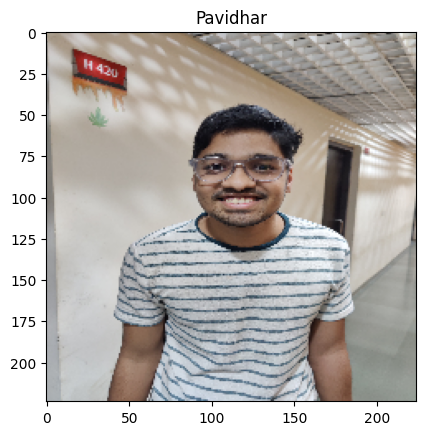

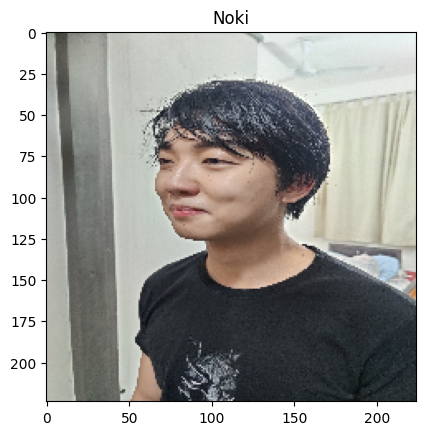

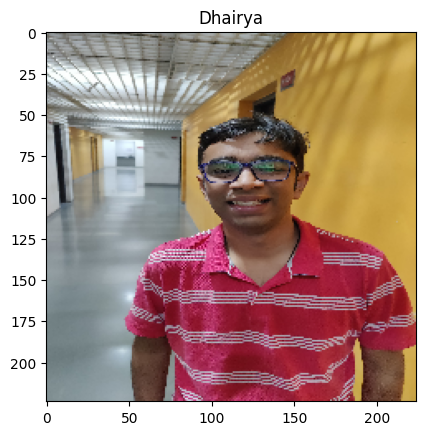

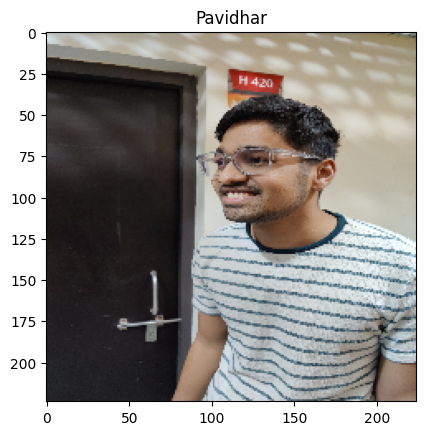

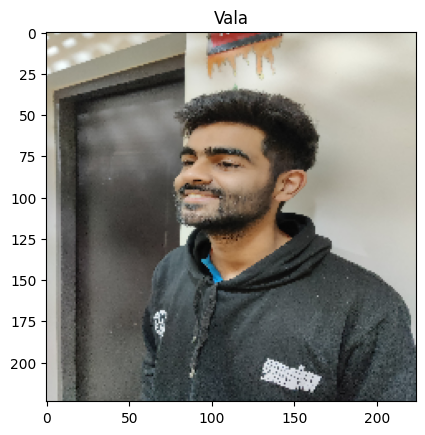

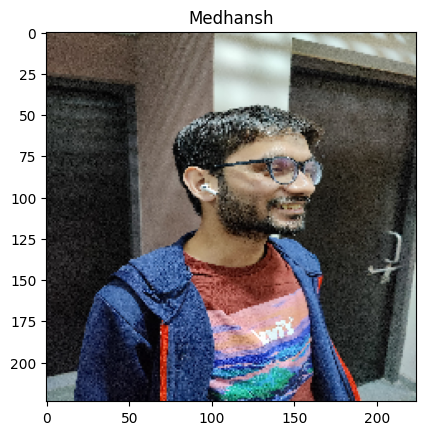

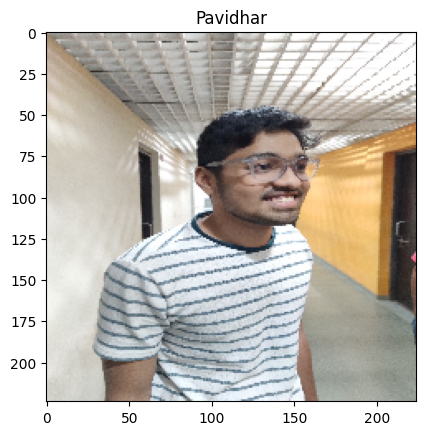

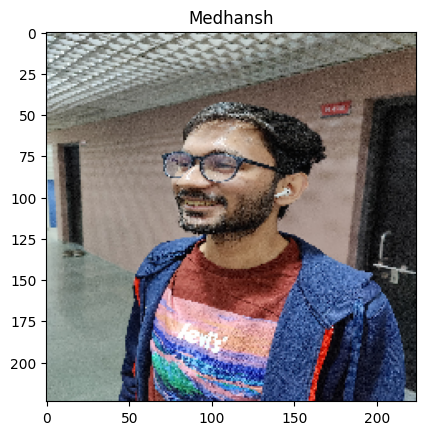

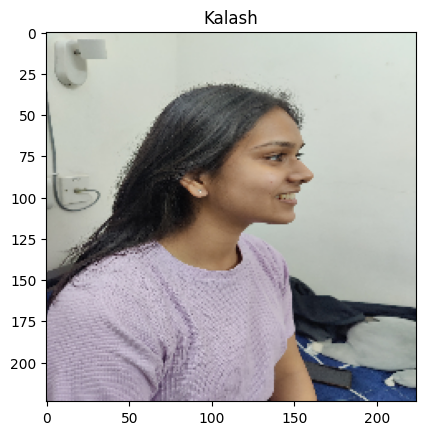

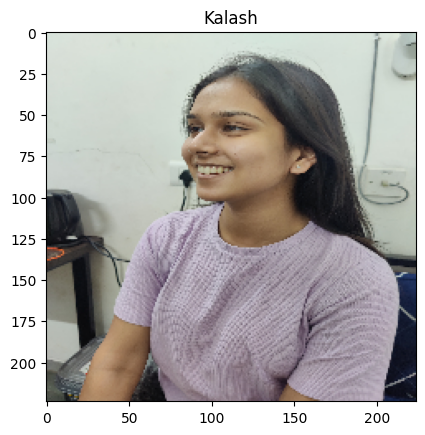

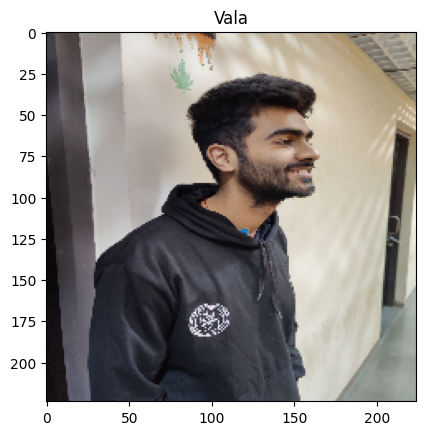

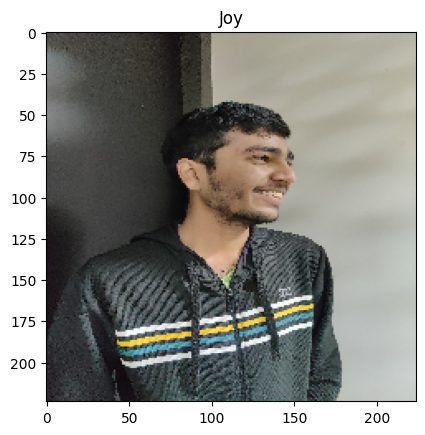

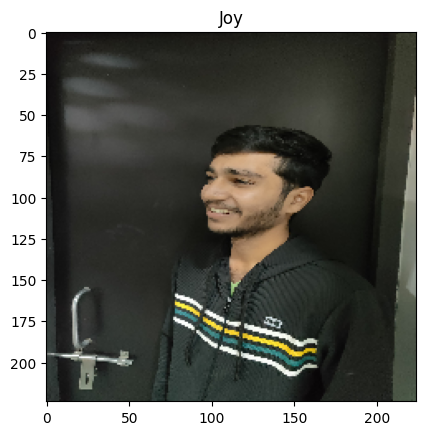

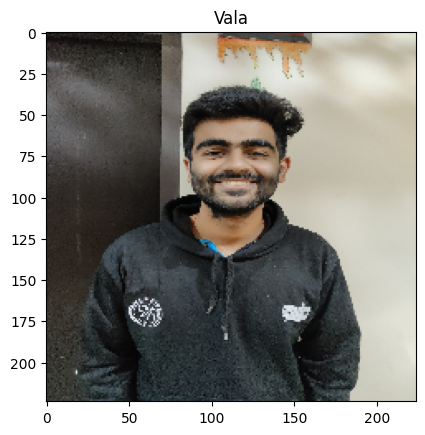

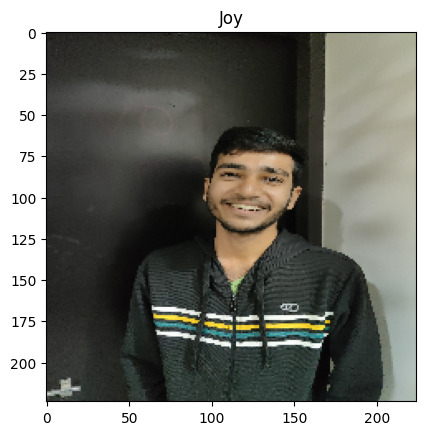

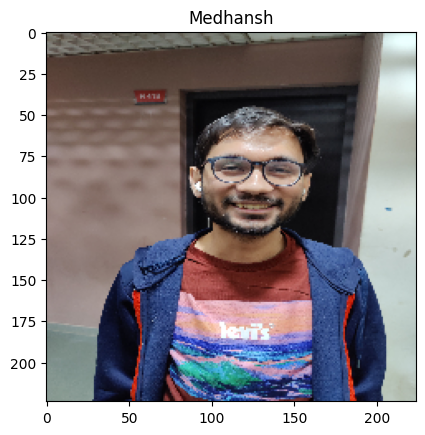

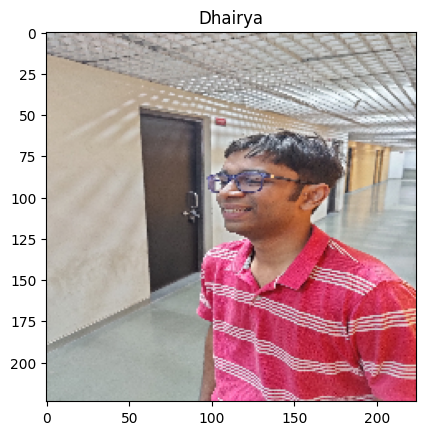

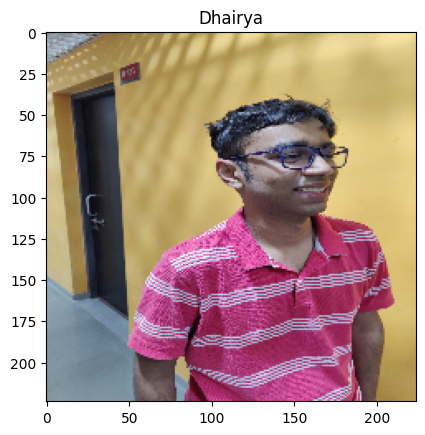

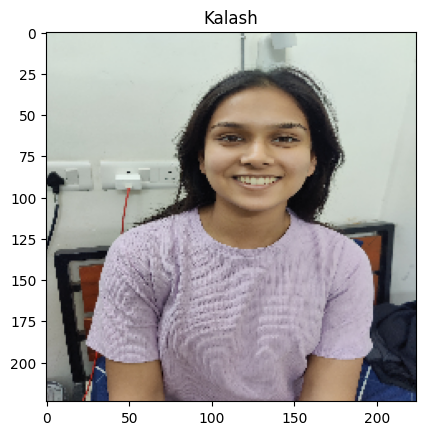

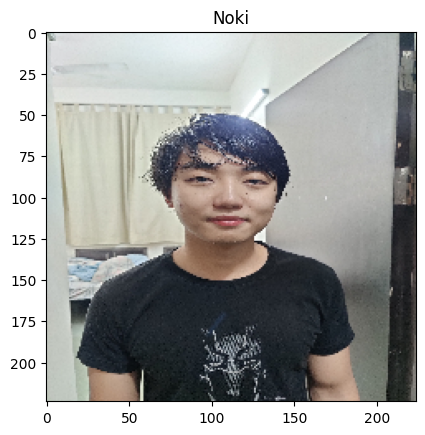

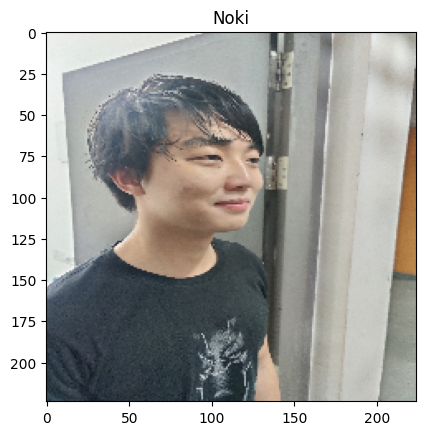

In [14]:
# Print all the labels and display the images
for i, sample in enumerate(train_loader):
    img = sample['image']
    model_pretrained.eval()
    out = model_pretrained(img)
    _, predicted = torch.max(out, 1)
    display_img(img[0], predicted[0].item())

In [15]:
accuracy(model_pretrained, retain_loader)

100.0

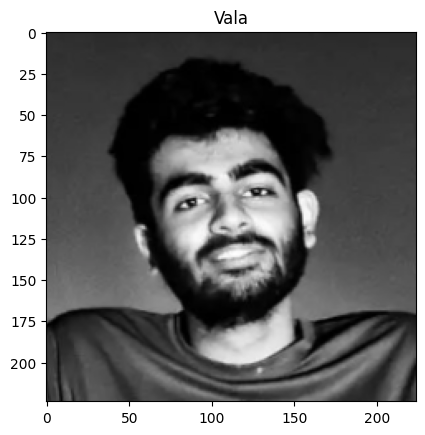

In [17]:
test_img = torchvision.io.read_image('Faces/TestIMG.png')
test_img = torchvision.transforms.functional.resize(test_img, (224, 224))
# Remove 1 channel from the image
test_img = test_img[0:3]
test_img = test_img.to(torch.float32)
out = model_pretrained(test_img.unsqueeze(0))
_, predicted = torch.max(out, 1)
display_img(test_img, predicted[0].item())

In [18]:
# Sigmoind of output
out_prob = F.softmax(out, dim=1)
out_prob = sorted(out_prob[0].tolist(), reverse=True)
out_prob[0] - out_prob[1]

0.4761529266834259

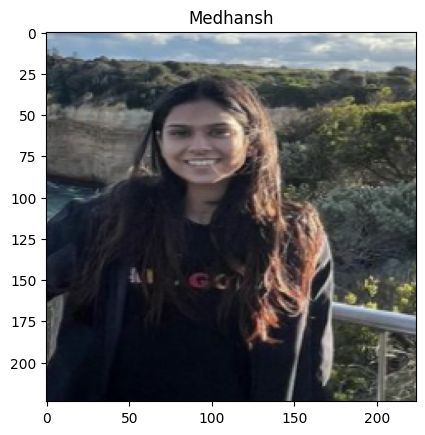

In [19]:
test_img = torchvision.io.read_image('Faces/TestIMG2.png')
test_img = torchvision.transforms.functional.resize(test_img, (224, 224))

# Remove 1 channel from the image
test_img = test_img[0:3]
test_img = test_img.to(torch.float32)

out = model_pretrained(test_img.unsqueeze(0))
_, predicted = torch.max(out, 1)
display_img(test_img, predicted[0].item())

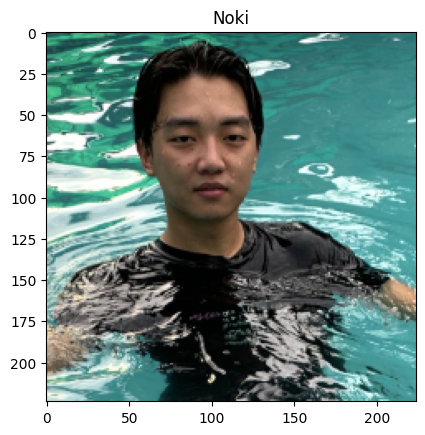

In [20]:
test_img = torchvision.io.read_image('Faces/TestIMG3.png')
test_img = torchvision.transforms.functional.resize(test_img, (224, 224))

# Remove 1 channel from the image
test_img = test_img[0:3]
test_img = test_img.to(torch.float32)

out = model_pretrained(test_img.unsqueeze(0))
_, predicted = torch.max(out, 1)
display_img(test_img, predicted[0].item())